## GPR - 1dim Data / Gaussian / Exact


In [37]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
import arviz as az

from toygp import gp, kernels

In [38]:
numpyro.set_platform('cpu')
numpyro.set_host_device_count(4)

In [39]:
jax.config.update('jax_enable_x64', True)

## Generate Keys

In [40]:
keys = jax.random.split(jax.random.PRNGKey(1), num=10)

## Generate Data

In [41]:
num_data = 500

X = 10 * jnp.sort(jax.random.uniform(keys[0], shape=(num_data,)))[:, None]
X.shape

(500, 1)

In [42]:
rho_true = 1.0
var_true = 3.0

kf = lambda x, y : var_true * kernels.rbf(x, y, rho_true)

v = dist.Normal(0, 1).sample(keys[1], sample_shape=(num_data,))
f_true = gp.exact(kf, X, v)

In [43]:
noise_true = 0.5

y = f_true + noise_true * dist.Normal(0, 1).sample(keys[2], sample_shape=(num_data,))

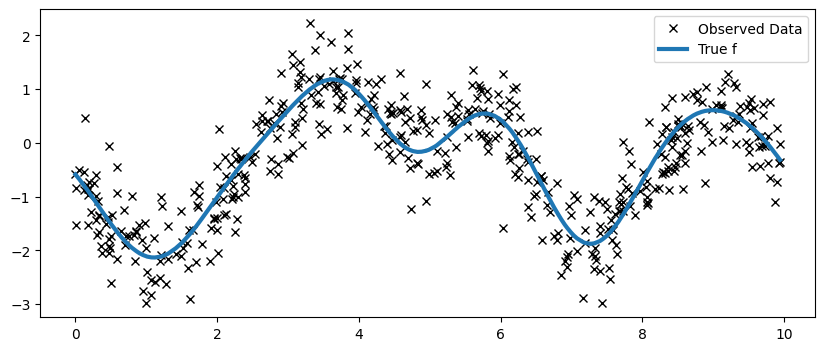

In [44]:
plt.figure(figsize=(10, 4))
plt.plot(X, y, 'kx', label='Observed Data')
plt.plot(X, f_true, lw=3, label='True f')
plt.legend()
plt.show()

## Define Model

In [45]:
def model(x, y=None):

    num_data = x.shape[0]

    #
    # Define Kernel Function
    #

    rho = numpyro.sample('rho', dist.Gamma(2, 1))
    var = numpyro.sample('var', dist.HalfNormal(10))
    kf = lambda x, y : var * kernels.rbf(x, y, rho)

    #
    # Define Gaussian Process
    #

    v = numpyro.sample('v', dist.Normal(0, 1), sample_shape=(num_data,))
    f = gp.exact(kf, x, v)

    #
    # Set Observed Data
    #

    numpyro.deterministic('f', f)

    noise_sd = numpyro.sample('noise_sd', dist.HalfNormal(10))

    with numpyro.plate('data', size=num_data):

        numpyro.sample('obs', dist.Normal(f, noise_sd), obs=y)

## Inference

In [46]:
guide = numpyro.infer.autoguide.AutoNormal(model)

optimizer = numpyro.optim.Adam(step_size=0.01)
svi = numpyro.infer.SVI(model, guide, optimizer, loss=numpyro.infer.Trace_ELBO())

In [47]:
%%time
svi_result = svi.run(keys[3], 5000, x=X, y=y)

100%|██████████| 5000/5000 [01:18<00:00, 63.73it/s, init loss: 2167.4166, avg. loss [4751-5000]: 497.1536]


CPU times: user 3min 10s, sys: 3min 34s, total: 6min 44s
Wall time: 1min 19s


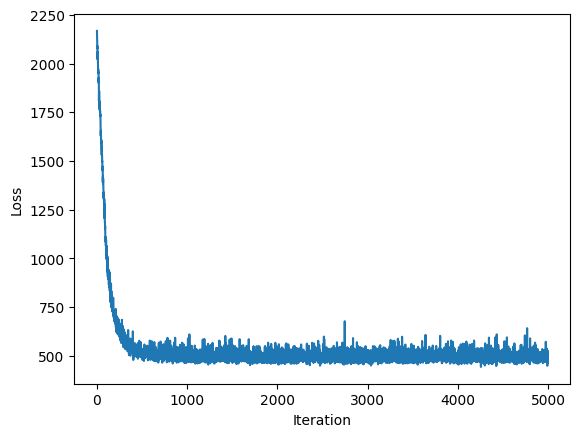

In [48]:
plt.plot(svi_result.losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

## Check Samples

To use arviz's visualization, posterior samples are generated as (2, 1000) to mimic 2-chain MCMC-samples.

In [49]:
posterior_samples = guide.sample_posterior(keys[4], svi_result.params, (2, 1000))
idata = az.from_dict(posterior_samples)

In [50]:
az.summary(idata, var_names=['var', 'rho', 'noise_sd'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
var,0.099,0.005,0.089,0.109,0.0,0.0,1999.0,1843.0,1.0
rho,0.628,0.010,0.607,0.646,0.0,0.0,1882.0,1961.0,1.0
noise_sd,0.575,0.018,0.541,0.609,0.0,0.0,2093.0,1760.0,1.0


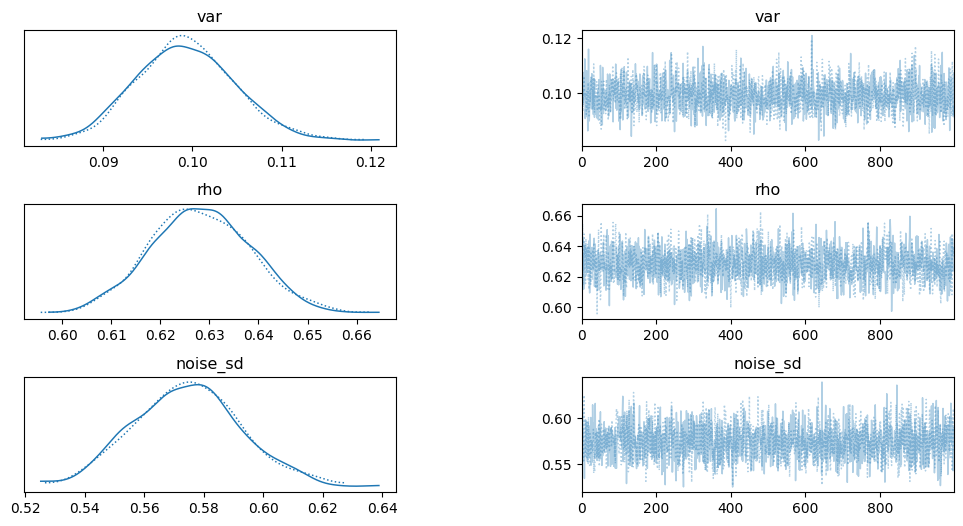

In [51]:
az.plot_trace(idata, var_names=['var', 'rho', 'noise_sd'])
plt.gcf().subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

## Posterior Predictive

In [52]:
posterior_samples = guide.sample_posterior(keys[4], svi_result.params, sample_shape=(1000,))

predictive = numpyro.infer.Predictive(model, posterior_samples)
predictive_samples = predictive(keys[5], x=X)

In [53]:
f = predictive_samples['f'][:100, :].T

y_mean = np.mean(predictive_samples['obs'], axis=0)
y_perc = np.percentile(predictive_samples['obs'], [5.0, 95.0], axis=0)

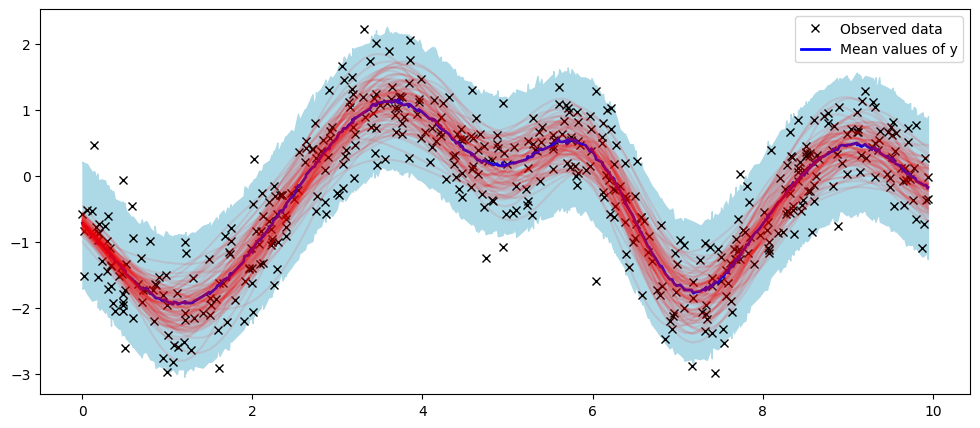

In [54]:
fig = plt.figure(figsize=(12, 5))

plt.plot(X, y, 'kx', label='Observed data')
plt.fill_between(X.flatten(), y_perc[0, :], y_perc[1, :], color='lightblue')
plt.plot(X.flatten(), y_mean, 'blue', ls='solid', lw=2.0, label='Mean values of y')
plt.plot(X.flatten(), f, 'red', alpha=0.1)
plt.legend()
plt.show()

## Caution

If you want to predict y for new x, please use sparse GP.